In [1]:
import operator
import functools
import os
from dotenv import load_dotenv
from typing import List,Annotated, Optional,Dict,TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma
from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage,BaseMessage,SystemMessage,ToolMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langgraph.graph.message import add_messages


In [16]:
load_dotenv()
GOOGLE_API_KEY=os.environ["GOOGLE_API_KEY"]
persist_directory = 'docs/chroma/'

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_tokens=250,
    temperature=0.5)

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vectorstore = Chroma(persist_directory=persist_directory,
                              embedding_function=embeddings,
                              collection_name = "guide_questions")

question_retriever = vectorstore.as_retriever()

In [19]:
retrieved_docs = question_retriever.invoke("Polar issues",k=1)
retrieved_docs_str = "\n".join([doc.page_content for doc in retrieved_docs])
print(retrieved_docs_str)

Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1


Device
Failure
scenarios
for
the
systems
1.
Polar
●
Failure
case:-
Direct
power
source
is
power
off
or
removed 
○
Question
:-
Is
the
device's
adapter
AC
current
connected? 
●
Failure
case:-
Temparature
sensor
is
malfunctioning 
○
Question
:-
Is
there
a
potal
solwing
sensor
error? 
○
Question
:-
Is
sensor
wire
damaged? 
2.
Common
●
Failure
case:-
SIM
damaged 
○
Question
:-
Is
water
present
inside
the
sensor/are
there
rust
inside
the 
sensor
circuitry 
●
Failure
case:-
GSM
module
damaged 
○
Question
:-
Is
there
an
LED
blinking
within
the
device? 
○
Question
:-
Is
there
water
inside
the
device?
○
Question
:-
Is
sensor
wire
damaged? 
●
Failure
Case:-
GSM
module
loss
connection
with
main
board 
○
Question
:-
Is
the
board's
LED
working? 
○
Question
:-
Is
the
device's
GSM
LED
off?


In [3]:
@tool("pdf_question_vdb_tool")
def pdf_question_vdb_tool(query:str) -> str:
  """
  Search for questions to be asked regarding failures of devices for the provided user query.

  Args:
      query (str): user query which can be the question or any request related to the device failure details.

  Returns:
      str: retrieved relevant question from the documents for the user query which is formatted into string datatype
  """
  retrieved_docs = question_retriever.invoke(query)

  retrieved_docs_str = "\n".join([doc.page_content for doc in retrieved_docs])
  return retrieved_docs_str

In [4]:
class AgentState(TypedDict):
    messages:Annotated[list,add_messages]

In [5]:
tools = [pdf_question_vdb_tool]

In [33]:
class Agent:
    def __init__(self,tools, model, prompt):
        self.prompt = prompt
        self.model = model
        graph = StateGraph(AgentState)
        graph.add_node("chatbot", self.call_llm)
        graph.add_node("tools", self.tool_action)
        graph.set_entry_point("chatbot")
        #graph.add_edge("chatbot", END)
        graph.add_edge("tools", "chatbot")
        graph.add_conditional_edges(
            "chatbot",
            self.exists_action,
            {True: "tools",False:END}
        )
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)


    def call_llm(self, state: AgentState):
        messages = state['messages']
        #if self.system:
        #    messages = [SystemMessage(content=self.system)] + messages
        self.chain = self.prompt|self.llm
        message = self.chain.invoke(
            messages)
        return {'messages': [message]}
    
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def tool_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [35]:
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an intelligent questioning assistant."
        "Based on the query you must decide the system and questions you should ask from the user"
        "You must retrieve the necessary question and question from the user"
        "Ask the suitable question from the user with the provided information"
    ),
    ("placeholder", "{messages}")
    ])
    

abot = Agent(tools,llm,prompt)

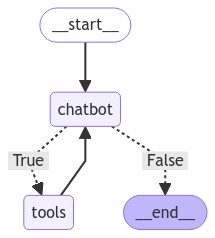

In [36]:
from IPython.display import Image, display

display(Image(abot.graph.get_graph().draw_mermaid_png()))


In [37]:
messages = [HumanMessage(content="Hi. my polar system isnt working. what could be the issue?")]
result = abot.graph.invoke({"messages": messages})

AttributeError: 'Agent' object has no attribute 'llm'

In [29]:
result['messages']

[HumanMessage(content='Hi. my polar device isnt working. any issues?', id='42f2c1fc-6edb-4695-8a51-0e7a4f3821b2'),
 AIMessage(content='Is your Polar device a watch, a heart rate monitor, or something else? \n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b3ceb78a-ce83-4802-bd30-162254bba069-0', usage_metadata={'input_tokens': 176, 'output_tokens': 16, 'total_tokens': 192})]

In [11]:
result

{'messages': [HumanMessage(content='Hi. my polar device isnt working. any issues?', id='2efbe52d-9426-4c92-bad1-014535355998'),
  AIMessage(content='I can help you with that.  What kind of Polar device is it? \n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-6f9b8968-24b4-42e7-8e20-9d786eb86c41-0', usage_metadata={'input_tokens': 180, 'output_tokens': 16, 'total_tokens': 196})]}